# DA6 - Image Captioning Model
Goutham Krishnan 21BAI1007

In [30]:
!pip install kagglehub opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 171.5 MB/s eta 0:00:00a 0:00:01


In [31]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

### Data Extraction and Cleaning

In [4]:
import kagglehub

path = kagglehub.dataset_download("nikhil7280/coco-image-caption")

print("Path to dataset files:", path)

100%|██████████| 13.7G/13.7G [01:37<00:00, 151MB/s] 

Extracting files...


Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1


In [5]:
class CocoDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform, tokenizer, max_seq_length):
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        self.image_ids = list(self.coco_data["annotations"])
        self.image_info = {img["id"]: img for img in self.coco_data["images"]}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        annotation = self.image_ids[idx]
        image_id = annotation["image_id"]
        caption = annotation["caption"]

        image_path = os.path.join(self.image_dir, self.image_info[image_id]["file_name"])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        tokenized_caption = self.tokenizer(caption, max_length=self.max_seq_length, padding="max_length", truncation=True)
        return image, torch.tensor(tokenized_caption["input_ids"]), torch.tensor(tokenized_caption["attention_mask"])

### CNN and LSTM Encoder Decoder Model

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        cnn = models.resnet50(pretrained=True)
        for param in cnn.parameters():
            param.requires_grad = False
        self.feature_extractor = nn.Sequential(*list(cnn.children())[:-1])
        self.fc = nn.Linear(cnn.fc.in_features, embed_size)
        self.relu = nn.ReLU()

    def forward(self, images):
        features = self.feature_extractor(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return self.relu(features)

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions[:, :-1])
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        lstm_outputs, _ = self.lstm(inputs)
        return self.fc(lstm_outputs)

In [8]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

### Training Loop

In [9]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, captions, _ in tqdm(dataloader):
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions)
            loss = criterion(outputs.view(-1, outputs.size(-1)), captions.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}")

In [10]:
def generate_caption(model, image, tokenizer, max_length, device):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))
        caption = [tokenizer.cls_token_id]
        for _ in range(max_length):
            inputs = torch.tensor(caption).unsqueeze(0).to(device)
            output = model.decoder(features, inputs)
            next_token = output.argmax(2)[:, -1].item()
            caption.append(next_token)
            if next_token == tokenizer.sep_token_id:
                break
        return tokenizer.decode(caption, skip_special_tokens=True)

In [22]:
from transformers import AutoTokenizer

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_seq_length = 30

dataset = CocoDataset(
    annotation_file = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json",
    image_dir = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014",
    transform=transform,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 512
vocab_size = len(tokenizer.vocab)
num_layers = 1

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
model = ImageCaptioningModel(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, dataloader, criterion, optimizer, device, num_epochs=3)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/zeus/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
  0%|          | 0.00/97.8M [00:00<?, ?B/s]

100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]
100%|██████████| 12942/12942 [12:36<00:00, 17.11it/s]


Epoch 1/3, Loss: 3.101755610676236


100%|██████████| 12942/12942 [12:40<00:00, 17.01it/s]


Epoch 2/3, Loss: 2.4412776324613037


100%|██████████| 12942/12942 [12:41<00:00, 17.00it/s]

Epoch 3/3, Loss: 2.275193364538046


In [24]:
## Save the  model
torch.save(model.state_dict(), "image_caption.pth")

### Sample Image Caption Generated

Generated Caption: a a herd herd of of zebra zebrass grazing in in a a field field..


Text(0.5, 1.0, 'Image')

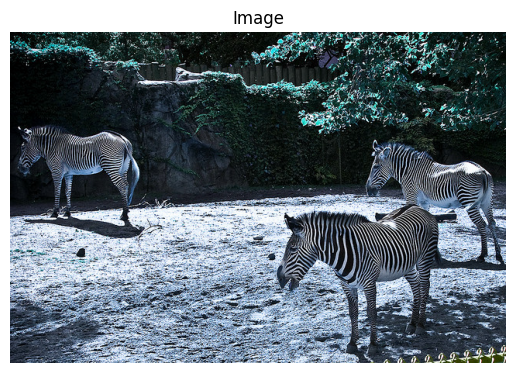

In [32]:
test_image = transform(Image.open("/teamspace/studios/this_studio/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014/COCO_train2014_000000462052.jpg").convert("RGB")).to(device)
caption = generate_caption(model, test_image, tokenizer, max_seq_length, device)
print("Generated Caption:", caption)
img = cv2.imread("/teamspace/studios/this_studio/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014/COCO_train2014_000000462052.jpg")
plt.imshow(img)
plt.axis("off")
plt.title("Image")